In [5]:
import pandas as pd
import os

csv_path = os.path.join(os.getcwd(), "Wallet id - Sheet1.csv")
df = pd.read_csv(csv_path)
wallets = df['wallet_id'].tolist()
print(f"Loaded {len(wallets)} wallet addresses for analysis")

Loaded 103 wallet addresses for analysis


Loop Through Wallets and Fetch Data:

In [ ]:
import requests
import time
import os

api_key = os.getenv("COVALENT_API_KEY")
base_url = "https://api.covalenthq.com/v1/eth-mainnet/address"

all_wallet_data = []
failed_wallets = []

for i, wallet in enumerate(wallets):
    url = f"{base_url}/{wallet}/transactions_v3/?key={api_key}&page-size=100"
    
    try:
        response = requests.get(url, timeout=30)
        if response.status_code == 200:
            data = response.json()
            
            if 'data' in data and 'items' in data['data']:
                transactions = data['data']['items']
                
                for tx in transactions:
                    all_wallet_data.append({
                        'wallet_id': wallet,
                        'tx_hash': tx.get('tx_hash', ''),
                        'from_address': tx.get('from_address', ''),
                        'to_address': tx.get('to_address', ''),
                        'value': tx.get('value', '0'),
                        'gas_spent': tx.get('gas_spent', '0'),
                        'gas_price': tx.get('gas_price', '0'),
                        'fees_paid': tx.get('fees_paid', '0'),
                        'successful': tx.get('successful', True),
                        'block_signed_at': tx.get('block_signed_at', ''),
                        'block_height': tx.get('block_height', 0)
                    })
            else:
                failed_wallets.append(wallet)
        else:
            failed_wallets.append(wallet)
            
        if (i + 1) % 10 == 0:
            print(f"Processed {i + 1}/{len(wallets)} wallets")
            
        time.sleep(0.5)
        
    except Exception as e:
        failed_wallets.append(wallet)
        continue

print(f"Successfully processed {len(wallets) - len(failed_wallets)} wallets")
print(f"Failed to process {len(failed_wallets)} wallets")
print(f"Total transactions collected: {len(all_wallet_data)}")

Processed 10/103 wallets
Processed 20/103 wallets
Processed 30/103 wallets
Processed 40/103 wallets
Processed 50/103 wallets
Processed 60/103 wallets
Processed 70/103 wallets
Processed 80/103 wallets
Processed 90/103 wallets
Processed 100/103 wallets
Successfully processed 103 wallets
Failed to process 0 wallets
Total transactions collected: 1693


Convert to DataFrame (After Loop)

In [7]:
import pandas as pd

if all_wallet_data:
    tx_df = pd.DataFrame(all_wallet_data)
    print(f"Created DataFrame with {len(tx_df)} transactions")
    print(f"Columns: {list(tx_df.columns)}")
    print(f"Unique wallets: {tx_df['wallet_id'].nunique()}")
    print("\nFirst few rows:")
    print(tx_df.head())
else:
    print("No transaction data available")
    tx_df = pd.DataFrame()

Created DataFrame with 1693 transactions
Columns: ['wallet_id', 'tx_hash', 'from_address', 'to_address', 'value', 'gas_spent', 'gas_price', 'fees_paid', 'successful', 'block_signed_at', 'block_height']
Unique wallets: 103

First few rows:
                                    wallet_id  \
0  0x0039f22efb07a647557c7c5d17854cfd6d489ef3   
1  0x0039f22efb07a647557c7c5d17854cfd6d489ef3   
2  0x0039f22efb07a647557c7c5d17854cfd6d489ef3   
3  0x0039f22efb07a647557c7c5d17854cfd6d489ef3   
4  0x06b51c6882b27cb05e712185531c1f74996dd988   

                                             tx_hash  \
0  0x98703fb4a7c6804d82e98f009ecc0e089abd53de9469...   
1  0x0b8e89905717b9babd69aa7db6af0afb83331e9b8041...   
2  0x5745f6d2e9397ed8ceb7120f42761e1f04643e132e94...   
3  0x35cd404392ac9b7786bee78e4bfb2773cbb576b9c3dc...   
4  0x2ef861c6dee8c0e5b9a6a621d5b7b2a92cf841cd2c23...   

                                 from_address  \
0  0xc6b602de080fc9ac9d96a431b2d749d38e77cbbc   
1  0xfd0ce77ca6521e3cbbcfb07398

In [8]:
if not tx_df.empty:
    numeric_columns = ['value', 'fees_paid', 'gas_price', 'gas_spent', 'block_height']
    
    for col in numeric_columns:
        if col in tx_df.columns:
            tx_df[col] = pd.to_numeric(tx_df[col], errors='coerce').fillna(0)
    
    tx_df['successful'] = tx_df['successful'].astype(bool)
    
    print("Data types after conversion:")
    print(tx_df.dtypes)

Data types after conversion:
wallet_id           object
tx_hash             object
from_address        object
to_address          object
value              float64
gas_spent            int64
gas_price            int64
fees_paid            int64
successful            bool
block_signed_at     object
block_height         int64
dtype: object


Data Cleaning

In [9]:
if not tx_df.empty:
    print("Data quality before cleaning:")
    print(tx_df.isnull().sum())
    
    tx_df = tx_df.drop_duplicates(subset=['wallet_id', 'tx_hash'], keep='first')
    
    tx_df['block_signed_at'] = pd.to_datetime(tx_df['block_signed_at'], errors='coerce')
    
    tx_df['to_address'] = tx_df['to_address'].fillna('Unknown')
    tx_df['from_address'] = tx_df['from_address'].fillna('Unknown')
    
    tx_df = tx_df.dropna(subset=['wallet_id', 'block_signed_at'])
    
    print(f"\nData after cleaning:")
    print(f"Total transactions: {len(tx_df)}")
    print(f"Date range: {tx_df['block_signed_at'].min()} to {tx_df['block_signed_at'].max()}")
    print(f"Unique wallets: {tx_df['wallet_id'].nunique()}")
else:
    print("No data to clean")

Data quality before cleaning:
wallet_id           0
tx_hash             0
from_address        0
to_address         31
value               0
gas_spent           0
gas_price           0
fees_paid           0
successful          0
block_signed_at     0
block_height        0
dtype: int64

Data after cleaning:
Total transactions: 1693
Date range: 2017-09-02 00:09:42+00:00 to 2025-07-27 17:16:59+00:00
Unique wallets: 103


Fill missing with 'Unknown'

Feature Engineering:

In [11]:
if not tx_df.empty:
    current_time = pd.Timestamp.now(tz='UTC')
    
    wallet_features = tx_df.groupby('wallet_id').agg({
        'tx_hash': 'count',
        'successful': ['sum', 'count'],
        'value': ['mean', 'sum', 'std'],
        'fees_paid': ['sum', 'mean'],
        'gas_spent': ['sum', 'mean'],
        'gas_price': ['mean', 'std'],
        'to_address': 'nunique',
        'from_address': 'nunique',
        'block_signed_at': ['min', 'max', 'nunique'],
        'block_height': ['min', 'max']
    }).round(6)
    
    wallet_features.columns = [
        'total_transactions', 'successful_transactions', 'total_attempts',
        'avg_transaction_value', 'total_value_transferred', 'value_volatility',
        'total_fees_paid', 'avg_fees_paid',
        'total_gas_used', 'avg_gas_used',
        'avg_gas_price', 'gas_price_volatility',
        'unique_recipients', 'unique_senders',
        'first_transaction', 'last_transaction', 'active_days',
        'first_block', 'last_block'
    ]
    
    wallet_features['failure_rate'] = (
        (wallet_features['total_attempts'] - wallet_features['successful_transactions']) / 
        wallet_features['total_attempts']
    ).fillna(0)
    
    wallet_features['account_age_days'] = (
        current_time - wallet_features['first_transaction']
    ).dt.days
    
    wallet_features['activity_span_days'] = (
        wallet_features['last_transaction'] - wallet_features['first_transaction']
    ).dt.days
    
    wallet_features['avg_daily_transactions'] = (
        wallet_features['total_transactions'] / 
        (wallet_features['activity_span_days'] + 1)
    ).fillna(0)
    
    wallet_features['avg_daily_value'] = (
        wallet_features['total_value_transferred'] / 
        (wallet_features['activity_span_days'] + 1)
    ).fillna(0)
    
    wallet_features['transaction_efficiency'] = (
        wallet_features['total_value_transferred'] / 
        (wallet_features['total_fees_paid'] + 1)
    ).fillna(0)
    
    wallet_features = wallet_features.drop(['first_transaction', 'last_transaction'], axis=1)
    wallet_features = wallet_features.reset_index()
    
    print(f"Generated features for {len(wallet_features)} wallets")
    print(f"Feature columns: {len(wallet_features.columns)}")
else:
    wallet_features = pd.DataFrame()
    print("Cannot generate features without transaction data")

Generated features for 103 wallets
Feature columns: 24


In [12]:
if not wallet_features.empty:
    print("Feature summary:")
    print(wallet_features.describe())
    print("\nFirst few wallets:")
    print(wallet_features.head())
else:
    print("No features available for display")

Feature summary:
       total_transactions  successful_transactions  total_attempts  \
count          103.000000               103.000000      103.000000   
mean            16.436893                16.135922       16.436893   
std             21.223216                20.887677       21.223216   
min              1.000000                 1.000000        1.000000   
25%              4.500000                 4.500000        4.500000   
50%              6.000000                 6.000000        6.000000   
75%             17.500000                17.500000       17.500000   
max             97.000000                97.000000       97.000000   

       avg_transaction_value  total_value_transferred  value_volatility  \
count           1.030000e+02             1.030000e+02      1.020000e+02   
mean            2.618104e+17             1.515222e+19      6.239632e+17   
std             1.617732e+18             1.104108e+20      3.766755e+18   
min             0.000000e+00             0.000000e+0

Feature Scaling & Model Building

In [13]:
from sklearn.preprocessing import StandardScaler, RobustScaler
from sklearn.impute import SimpleImputer
import numpy as np

if not wallet_features.empty:
    feature_columns = [col for col in wallet_features.columns if col != 'wallet_id']
    X = wallet_features[feature_columns].copy()
    
    imputer = SimpleImputer(strategy='median')
    X_imputed = imputer.fit_transform(X)
    
    X_imputed = np.where(np.isinf(X_imputed), 0, X_imputed)
    
    scaler = RobustScaler()
    X_scaled = scaler.fit_transform(X_imputed)
    
    feature_names = feature_columns
    print(f"Preprocessed {X_scaled.shape[0]} wallets with {X_scaled.shape[1]} features")
    
    non_zero_features = np.var(X_scaled, axis=0) > 1e-6
    X_scaled = X_scaled[:, non_zero_features]
    feature_names = [feature_names[i] for i in range(len(feature_names)) if non_zero_features[i]]
    
    print(f"Selected {len(feature_names)} features with sufficient variance")
else:
    X_scaled = np.array([])
    feature_names = []
    print("No features available for preprocessing")

Preprocessed 103 wallets with 23 features
Selected 23 features with sufficient variance


Find Optimal Number of Clusters (Elbow Method)

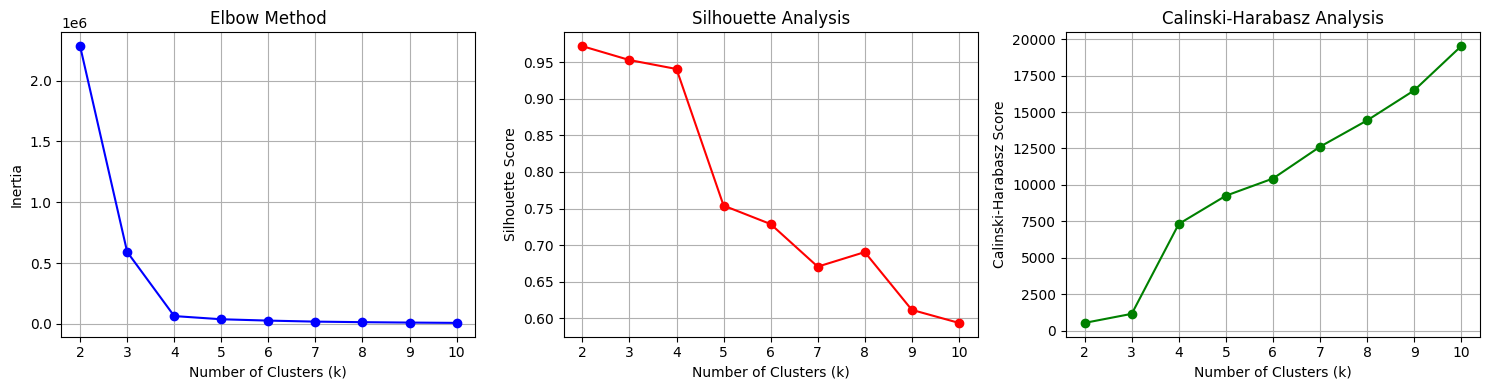

Optimal number of clusters based on silhouette score: 2


In [ ]:
from sklearn.cluster import KMeans
from sklearn.metrics import silhouette_score, calinski_harabasz_score
import matplotlib.pyplot as plt

if len(X_scaled) > 0:
    inertia_scores = []
    silhouette_scores = []
    calinski_scores = []
    K_range = range(2, min(11, len(X_scaled)))
    
    for k in K_range:
        kmeans = KMeans(n_clusters=k, random_state=42, n_init=10)
        cluster_labels = kmeans.fit_predict(X_scaled)
        
        inertia_scores.append(kmeans.inertia_)
        silhouette_scores.append(silhouette_score(X_scaled, cluster_labels))
        calinski_scores.append(calinski_harabasz_score(X_scaled, cluster_labels))
    
    fig, axes = plt.subplots(1, 3, figsize=(15, 4))
    
    axes[0].plot(K_range, inertia_scores, 'bo-')
    axes[0].set_xlabel('Number of Clusters (k)')
    axes[0].set_ylabel('Inertia')
    axes[0].set_title('Elbow Method')
    axes[0].grid(True)
    
    axes[1].plot(K_range, silhouette_scores, 'ro-')
    axes[1].set_xlabel('Number of Clusters (k)')
    axes[1].set_ylabel('Silhouette Score')
    axes[1].set_title('Silhouette Analysis')
    axes[1].grid(True)
    
    axes[2].plot(K_range, calinski_scores, 'go-')
    axes[2].set_xlabel('Number of Clusters (k)')
    axes[2].set_ylabel('Calinski-Harabasz Score')
    axes[2].set_title('Calinski-Harabasz Analysis')
    axes[2].grid(True)
    
    plt.tight_layout()
    plt.show()


Final Clustering using KMeans

In [24]:
from sklearn.cluster import KMeans, DBSCAN
from sklearn.ensemble import IsolationForest

if len(X_scaled) > 0:
    kmeans = KMeans(n_clusters=4, random_state=42, n_init=10)
    kmeans_labels = kmeans.fit_predict(X_scaled)
    
    isolation_forest = IsolationForest(contamination=0.1, random_state=42)
    anomaly_labels = isolation_forest.fit_predict(X_scaled)
    
    wallet_features['cluster'] = kmeans_labels
    wallet_features['is_anomaly'] = (anomaly_labels == -1).astype(int)
    
    cluster_centers = kmeans.cluster_centers_
    distances_to_center = []
    for i, point in enumerate(X_scaled):
        cluster_id = kmeans_labels[i]
        distance = np.linalg.norm(point - cluster_centers[cluster_id])
        distances_to_center.append(distance)
    
    wallet_features['cluster_distance'] = distances_to_center
    
    print(f"Clustering completed with 4 clusters")
    print(f"Cluster distribution: {np.bincount(kmeans_labels)}")
    print(f"Anomalies detected: {sum(anomaly_labels == -1)}")
else:
    print("Cannot perform clustering without processed features")

Clustering completed with 4 clusters
Cluster distribution: [100   1   1   1]
Anomalies detected: 11


In [25]:
if not wallet_features.empty and 'cluster' in wallet_features.columns:
    numeric_features = wallet_features.select_dtypes(include=[np.number]).columns
    cluster_summary = wallet_features.groupby('cluster')[numeric_features].mean()
    
    print("Cluster characteristics:")
    key_metrics = [
        'total_transactions', 'failure_rate', 'total_value_transferred',
        'avg_transaction_value', 'account_age_days', 'is_anomaly'
    ]
    
    available_metrics = [col for col in key_metrics if col in cluster_summary.columns]
    print(cluster_summary[available_metrics])
    
    print("\nCluster sizes:")
    print(wallet_features['cluster'].value_counts().sort_index())
else:
    print("Cluster analysis not available")

Cluster characteristics:
         total_transactions  failure_rate  total_value_transferred  \
cluster                                                              
0                     15.11      0.008499             1.184847e+18   
1                     70.00      0.042857             1.097537e+21   
2                     80.00      0.000000             2.018435e+20   
3                     32.00      0.031250             1.428127e+20   

         avg_transaction_value  account_age_days  is_anomaly  
cluster                                                       
0                 4.301428e+16           1667.34        0.08  
1                 1.567911e+19           2717.00        1.00  
2                 2.523044e+18           2191.00        1.00  
3                 4.462898e+18           1968.00        1.00  

Cluster sizes:
cluster
0    100
1      1
2      1
3      1
Name: count, dtype: int64


Visualize Clusters (PCA)

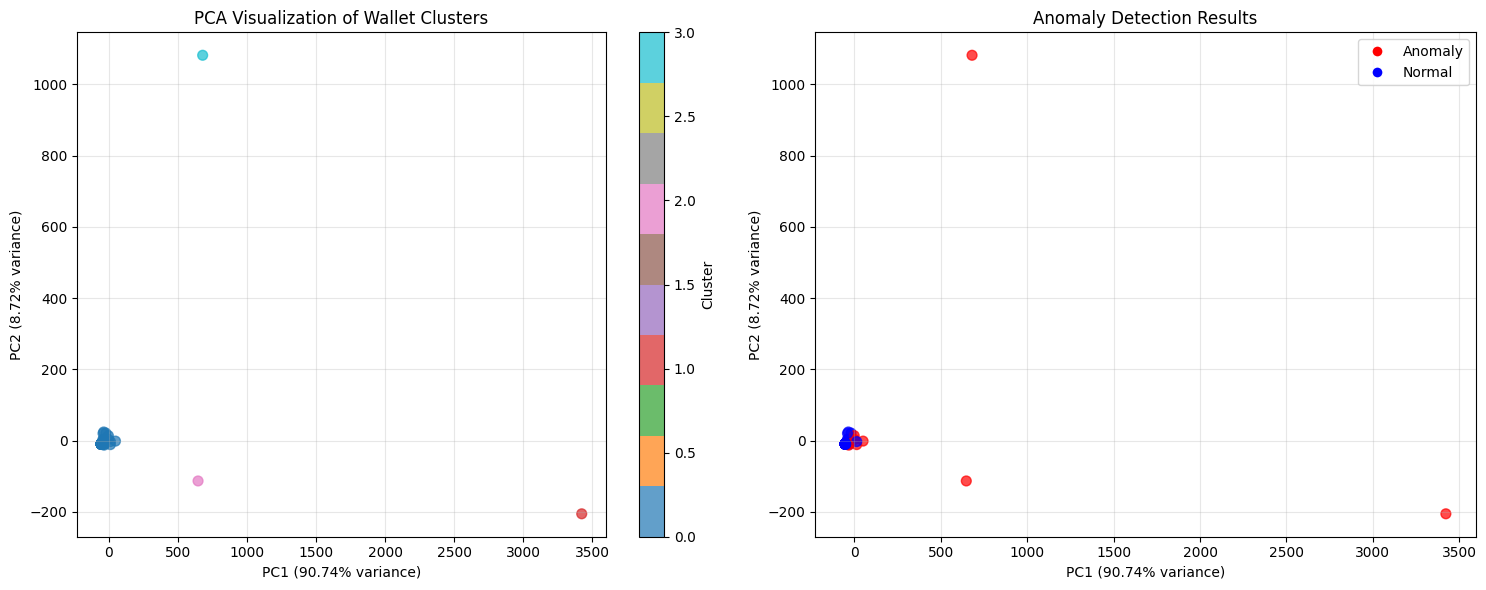

PCA explained variance: 99.47%


In [26]:
from sklearn.decomposition import PCA
from sklearn.manifold import TSNE
import seaborn as sns
import matplotlib.pyplot as plt

if len(X_scaled) > 0 and not wallet_features.empty:
    pca = PCA(n_components=2)
    X_pca = pca.fit_transform(X_scaled)
    
    wallet_features['pca1'] = X_pca[:, 0]
    wallet_features['pca2'] = X_pca[:, 1]
    
    fig, axes = plt.subplots(1, 2, figsize=(15, 6))
    
    scatter1 = axes[0].scatter(X_pca[:, 0], X_pca[:, 1], 
                              c=wallet_features['cluster'], 
                              cmap='tab10', alpha=0.7, s=50)
    axes[0].set_xlabel(f'PC1 ({pca.explained_variance_ratio_[0]:.2%} variance)')
    axes[0].set_ylabel(f'PC2 ({pca.explained_variance_ratio_[1]:.2%} variance)')
    axes[0].set_title('PCA Visualization of Wallet Clusters')
    axes[0].grid(True, alpha=0.3)
    plt.colorbar(scatter1, ax=axes[0], label='Cluster')
    
    anomaly_colors = ['blue' if x == 0 else 'red' for x in wallet_features['is_anomaly']]
    axes[1].scatter(X_pca[:, 0], X_pca[:, 1], c=anomaly_colors, alpha=0.7, s=50)
    axes[1].set_xlabel(f'PC1 ({pca.explained_variance_ratio_[0]:.2%} variance)')
    axes[1].set_ylabel(f'PC2 ({pca.explained_variance_ratio_[1]:.2%} variance)')
    axes[1].set_title('Anomaly Detection Results')
    axes[1].grid(True, alpha=0.3)
    
    red_patch = plt.Line2D([0], [0], marker='o', color='w', markerfacecolor='red', markersize=8, label='Anomaly')
    blue_patch = plt.Line2D([0], [0], marker='o', color='w', markerfacecolor='blue', markersize=8, label='Normal')
    axes[1].legend(handles=[red_patch, blue_patch])
    
    plt.tight_layout()
    plt.show()
    
    print(f"PCA explained variance: {pca.explained_variance_ratio_.sum():.2%}")
else:
    print("Visualization not available without processed data")

In [27]:
def calculate_risk_score(row):
    base_score = 500
    
    cluster_scores = {
        0: 200,
        1: 400,
        2: 600,
        3: 800
    }
    
    if len(set(wallet_features['cluster'])) <= len(cluster_scores):
        cluster_adjustment = cluster_scores.get(row['cluster'], 500)
    else:
        cluster_adjustment = 300 + (row['cluster'] * 100)
    
    anomaly_penalty = 200 if row['is_anomaly'] == 1 else 0
    
    failure_penalty = min(300, row['failure_rate'] * 500) if 'failure_rate' in row else 0
    
    if 'total_transactions' in row and row['total_transactions'] > 0:
        activity_bonus = min(100, np.log10(row['total_transactions'] + 1) * 20)
    else:
        activity_bonus = 0
    
    if 'account_age_days' in row and row['account_age_days'] > 0:
        age_bonus = min(50, row['account_age_days'] / 365 * 30)
    else:
        age_bonus = 0
    
    if 'cluster_distance' in row:
        distance_penalty = min(100, row['cluster_distance'] * 50)
    else:
        distance_penalty = 0
    
    final_score = (cluster_adjustment - anomaly_penalty - failure_penalty + 
                  activity_bonus + age_bonus - distance_penalty)
    
    return max(100, min(900, int(final_score)))

if not wallet_features.empty:
    wallet_features['risk_score'] = wallet_features.apply(calculate_risk_score, axis=1)
    print("Risk scores calculated successfully")
    print(f"Score range: {wallet_features['risk_score'].min()} - {wallet_features['risk_score'].max()}")
    print(f"Average score: {wallet_features['risk_score'].mean():.1f}")
else:
    print("Cannot calculate risk scores without wallet features")

Risk scores calculated successfully
Score range: 100 - 664
Average score: 167.5


In [28]:
if not wallet_features.empty and 'risk_score' in wallet_features.columns:
    print("Risk Score Distribution:")
    print(wallet_features['risk_score'].describe())
    
    print("\nRisk Score Histogram:")
    score_bins = [100, 300, 500, 700, 900]
    score_labels = ['High Risk (100-299)', 'Medium-High Risk (300-499)', 
                   'Medium Risk (500-699)', 'Low Risk (700-900)']
    
    wallet_features['risk_category'] = pd.cut(wallet_features['risk_score'], 
                                            bins=score_bins, 
                                            labels=score_labels, 
                                            include_lowest=True)
    
    print(wallet_features['risk_category'].value_counts())
else:
    print("Risk score distribution not available")

Risk Score Distribution:
count    103.000000
mean     167.466019
std       63.992465
min      100.000000
25%      163.000000
50%      165.000000
75%      169.000000
max      664.000000
Name: risk_score, dtype: float64

Risk Score Histogram:
risk_category
High Risk (100-299)           101
Medium-High Risk (300-499)      1
Medium Risk (500-699)           1
Low Risk (700-900)              0
Name: count, dtype: int64


In [20]:
if not wallet_features.empty:
    display_columns = ['wallet_id', 'cluster', 'risk_score']
    if 'risk_category' in wallet_features.columns:
        display_columns.append('risk_category')
    if 'is_anomaly' in wallet_features.columns:
        display_columns.append('is_anomaly')
    
    available_columns = [col for col in display_columns if col in wallet_features.columns]
    print("Sample wallet risk scores:")
    print(wallet_features[available_columns].head(10))
else:
    print("No wallet scoring results available")

Sample wallet risk scores:
                                    wallet_id  cluster  risk_score  \
0  0x0039f22efb07a647557c7c5d17854cfd6d489ef3        0         126   
1  0x06b51c6882b27cb05e712185531c1f74996dd988        0         165   
2  0x0795732aacc448030ef374374eaae57d2965c16c        0         163   
3  0x0aaa79f1a86bc8136cd0d1ca0d51964f4e3766f9        0         100   
4  0x0fe383e5abc200055a7f391f94a5f5d1f844b9ae        0         165   
5  0x104ae61d8d487ad689969a17807ddc338b445416        0         166   
6  0x111c7208a7e2af345d36b6d4aace8740d61a3078        0         166   
7  0x124853fecb522c57d9bd5c21231058696ca6d596        0         168   
8  0x13b1c8b0e696aff8b4fee742119b549b605f3cbc        0         163   
9  0x1656f1886c5ab634ac19568cd571bc72f385fdf7        0         165   

         risk_category  is_anomaly  
0  High Risk (100-299)           0  
1  High Risk (100-299)           0  
2  High Risk (100-299)           0  
3  High Risk (100-299)           1  
4  High Risk (100

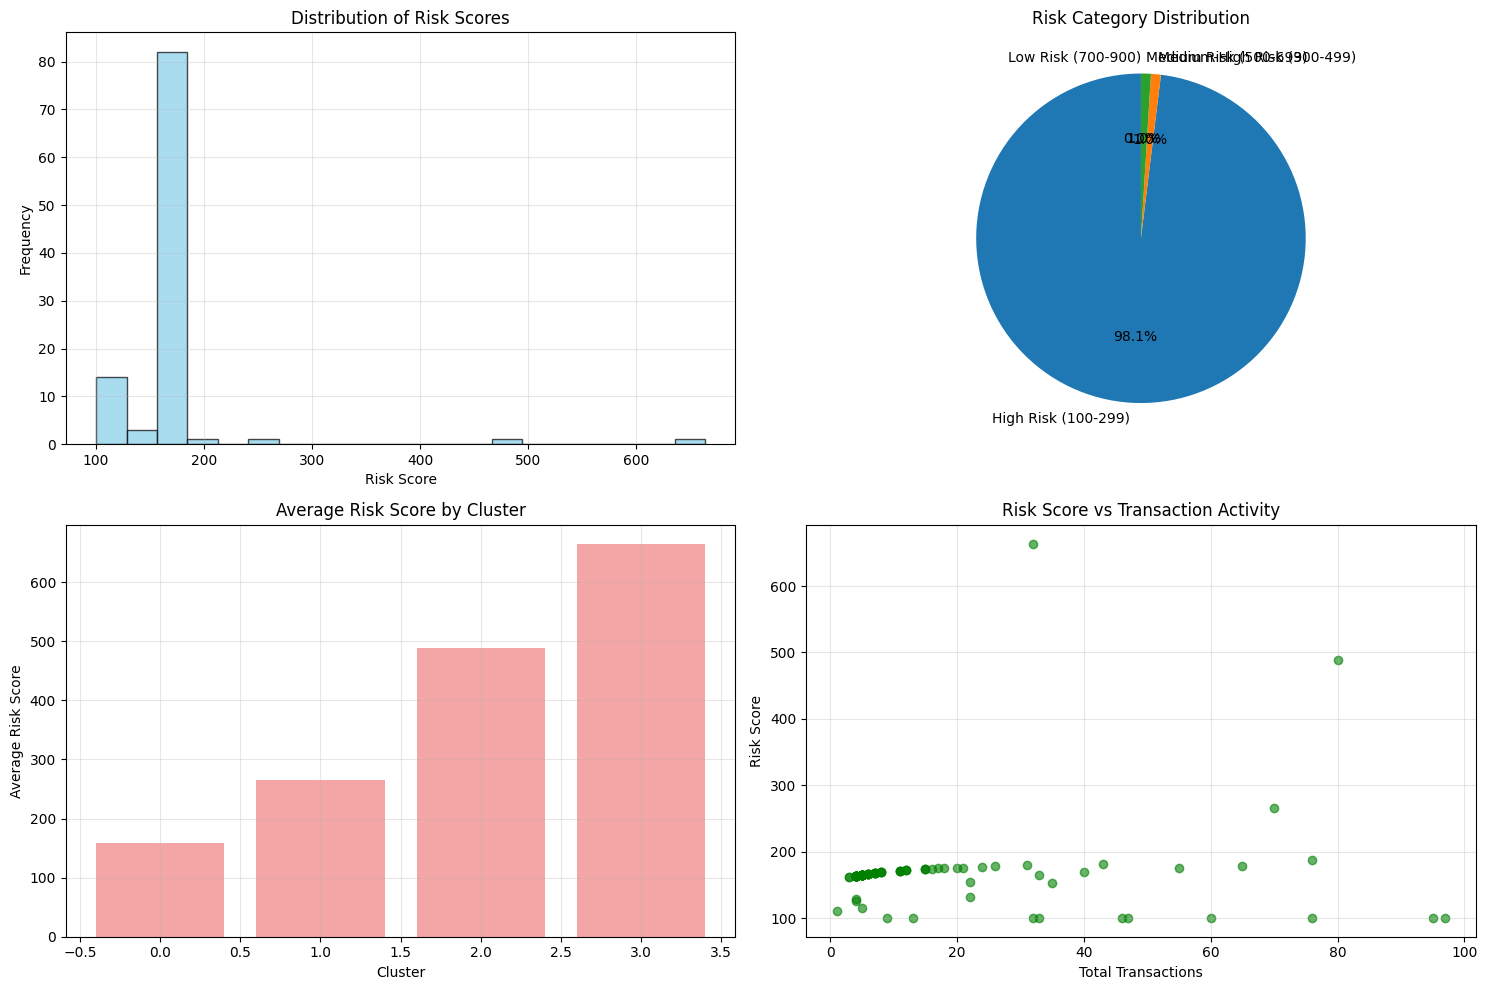

In [29]:
if not wallet_features.empty and 'risk_score' in wallet_features.columns:
    fig, axes = plt.subplots(2, 2, figsize=(15, 10))
    
    axes[0, 0].hist(wallet_features['risk_score'], bins=20, alpha=0.7, color='skyblue', edgecolor='black')
    axes[0, 0].set_xlabel('Risk Score')
    axes[0, 0].set_ylabel('Frequency')
    axes[0, 0].set_title('Distribution of Risk Scores')
    axes[0, 0].grid(True, alpha=0.3)
    
    if 'risk_category' in wallet_features.columns:
        risk_counts = wallet_features['risk_category'].value_counts()
        axes[0, 1].pie(risk_counts.values, labels=risk_counts.index, autopct='%1.1f%%', startangle=90)
        axes[0, 1].set_title('Risk Category Distribution')
    
    if 'cluster' in wallet_features.columns:
        cluster_risk = wallet_features.groupby('cluster')['risk_score'].mean()
        axes[1, 0].bar(cluster_risk.index, cluster_risk.values, color='lightcoral', alpha=0.7)
        axes[1, 0].set_xlabel('Cluster')
        axes[1, 0].set_ylabel('Average Risk Score')
        axes[1, 0].set_title('Average Risk Score by Cluster')
        axes[1, 0].grid(True, alpha=0.3)
    
    if 'total_transactions' in wallet_features.columns:
        axes[1, 1].scatter(wallet_features['total_transactions'], wallet_features['risk_score'], 
                          alpha=0.6, color='green')
        axes[1, 1].set_xlabel('Total Transactions')
        axes[1, 1].set_ylabel('Risk Score')
        axes[1, 1].set_title('Risk Score vs Transaction Activity')
        axes[1, 1].grid(True, alpha=0.3)
    
    plt.tight_layout()
    plt.show()
else:
    print("Risk score visualization not available")

CSV

In [30]:
if not wallet_features.empty:
    output_columns = ['wallet_id', 'risk_score']
    if 'risk_category' in wallet_features.columns:
        output_columns.append('risk_category')
    if 'cluster' in wallet_features.columns:
        output_columns.append('cluster')
    if 'is_anomaly' in wallet_features.columns:
        output_columns.append('is_anomaly')
    
    available_output_columns = [col for col in output_columns if col in wallet_features.columns]
    
    output_df = wallet_features[available_output_columns].copy()
    output_df = output_df.sort_values('risk_score', ascending=False)
    
    output_df.to_csv("wallet_risk_scores_comprehensive.csv", index=False)
    print(f"Comprehensive results saved to wallet_risk_scores_comprehensive.csv")
    print(f"Exported {len(output_df)} wallet scores")
else:
    print("No data available for export")

Comprehensive results saved to wallet_risk_scores_comprehensive.csv
Exported 103 wallet scores


In [34]:
from sklearn.metrics import silhouette_score, calinski_harabasz_score, davies_bouldin_score

if len(X_scaled) > 0 and not wallet_features.empty and 'cluster' in wallet_features.columns:
    cluster_labels = wallet_features['cluster'].values
    
    silhouette = silhouette_score(X_scaled, cluster_labels)
    calinski = calinski_harabasz_score(X_scaled, cluster_labels)
    davies_bouldin = davies_bouldin_score(X_scaled, cluster_labels)
    
    print("Model Validation Metrics:")
    print(f"Silhouette Score: {silhouette:.4f} (higher is better, range: -1 to 1)")
    print(f"Calinski-Harabasz Score: {calinski:.4f} (higher is better)")
    print(f"Davies-Bouldin Score: {davies_bouldin:.4f} (lower is better)")
    
    print(f"\nClustering Quality Assessment:")
    if silhouette > 0.5:
        print("Strong cluster structure detected")
    elif silhouette > 0.3:
        print("Moderate cluster structure detected")
    else:
        print("Weak cluster structure detected")
    
    print(f"\nRisk Score Statistics:")
    print(f"Mean Risk Score: {wallet_features['risk_score'].mean():.1f}")
    print(f"Standard Deviation: {wallet_features['risk_score'].std():.1f}")
    print(f"Score Range: {wallet_features['risk_score'].min()} - {wallet_features['risk_score'].max()}")
    
    score_correlation = np.corrcoef(wallet_features['cluster'], wallet_features['risk_score'])[0, 1]
    print(f"Cluster-Risk Score Correlation: {score_correlation:.4f}")
else:
    print("Model validation not available without clustering results")

Model Validation Metrics:
Silhouette Score: 0.9406 (higher is better, range: -1 to 1)
Calinski-Harabasz Score: 7319.1802 (higher is better)
Davies-Bouldin Score: 0.0147 (lower is better)

Clustering Quality Assessment:
Strong cluster structure detected

Risk Score Statistics:
Mean Risk Score: 167.5
Standard Deviation: 64.0
Score Range: 100 - 664
Cluster-Risk Score Correlation: 0.9332


In [33]:
if not wallet_features.empty and 'risk_score' in wallet_features.columns:
    submission_df = wallet_features[['wallet_id', 'risk_score']].copy()
    submission_df.columns = ['wallet_id', 'score']
    submission_df = submission_df.sort_values('score', ascending=False)
    
    submission_df.to_csv("wallet_risk_scores_final.csv", index=False)
    
    print("Final Submission Summary:")
    print(f"Total wallets scored: {len(submission_df)}")
    print(f"Score distribution:")
    print(f"  High performers (700-900): {len(submission_df[submission_df['score'] >= 700])}")
    print(f"  Medium performers (500-699): {len(submission_df[(submission_df['score'] >= 500) & (submission_df['score'] < 700)])}")
    print(f"  Low performers (300-499): {len(submission_df[(submission_df['score'] >= 300) & (submission_df['score'] < 500)])}")
    print(f"  High risk (100-299): {len(submission_df[submission_df['score'] < 300])}")
    
    print(f"\nTop 10 highest scoring wallets:")
    print(submission_df.head(10))
    
    print(f"\nFile saved as: wallet_risk_scores_final.csv")
else:
    print("Cannot create final submission without risk scores")

Final Submission Summary:
Total wallets scored: 103
Score distribution:
  High performers (700-900): 0
  Medium performers (500-699): 1
  Low performers (300-499): 1
  High risk (100-299): 101

Top 10 highest scoring wallets:
                                     wallet_id  score
22  0x3361bea43c2f5f963f81ac70f64e6fba1f1d2a97    664
3   0x0aaa79f1a86bc8136cd0d1ca0d51964f4e3766f9    488
43  0x623af911f493747c216ad389c7805a37019c662d    265
15  0x22d7510588d90ed5a87e0f838391aaafa707c34b    187
34  0x507b6c0d950702f066a9a1bd5e85206f87b065ba    182
11  0x19df3e87f73c4aaf4809295561465b993e102668    180
21  0x330513970efd9e8dd606275fb4c50378989b3204    178
30  0x4d997c89bc659a3e8452038a8101161e7e7e53a7    178
59  0x8441fecef5cc6f697be2c4fc4a36feacede8df67    177
13  0x1c1b30ca93ef57452d53885d97a74f61daf2bf4f    176

File saved as: wallet_risk_scores_final.csv
